# Generation Validity Rate Analysis

Analyzing how steering strength affects the model's ability to produce valid (A)/(B) responses across different model sizes.

In [1]:
import glob
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Load generation evaluation data
GEN_DIR = Path(os.path.expanduser("~/p/steering/results/generations"))
all_gens = []

for f in glob.glob(str(GEN_DIR / "*" / "Qwen_Qwen3_*" / "generations_*.csv")):
    df = pd.read_csv(f)
    all_gens.append(df)

gen_df = pd.concat(all_gens, ignore_index=True)
gen_df["model_size"] = gen_df["model"].str.extract(r"Qwen3-(\S+)")[0]

print(f"Loaded {len(gen_df)} generation samples")
print(f"Models: {sorted(gen_df['model_size'].dropna().unique().tolist())}")
print(f"Concepts: {sorted(gen_df['concept'].unique().tolist())}")
print(f"Steering strengths: {sorted(gen_df['strength'].unique().tolist())}")

Loaded 28440 generation samples
Models: ['0.6B', '1.7B', '14B', '32B', '4B', '8B']
Concepts: ['consciousness', 'corrigible_neutral_HHH', 'self_awareness_text_model', 'sycophancy']
Steering strengths: [-2.0, -1.0, -0.5, -0.25, -0.1, 0.0, 0.1, 0.25, 0.5, 1.0, 2.0]


In [3]:
# Calculate validity rate by model size and steering strength
# Filter out rows where model_size is NaN
gen_df_clean = gen_df.dropna(subset=["model_size"])

validity_by_model = gen_df_clean.groupby(["model_size", "strength"])["is_valid"].mean().reset_index()
validity_by_model.columns = ["model_size", "strength", "validity_rate"]

print("\nValidity rates by model size and strength:")
display(validity_by_model.pivot(index="model_size", columns="strength", values="validity_rate").round(3))


Validity rates by model size and strength:


strength,-2.00,-1.00,-0.50,-0.25,-0.10,0.00,0.10,0.25,0.50,1.00,2.00
model_size,,,,,,,,,,,
0.6B,0.920,0.925,0.916,0.905,0.905,0.894,0.883,0.906,0.894,0.875,0.875
1.7B,0.505,0.530,0.723,0.731,0.821,0.760,0.824,0.763,0.771,0.560,0.560
14B,0.785,0.835,0.834,0.847,0.850,0.848,0.857,0.860,0.861,0.910,0.900
32B,0.920,0.930,0.921,0.927,0.917,0.940,0.938,0.935,0.947,0.935,0.940
4B,0.475,0.735,0.869,0.853,0.888,0.845,0.902,0.879,0.903,0.675,0.500
8B,0.630,0.775,0.831,0.860,0.862,0.866,0.871,0.860,0.866,0.840,0.830


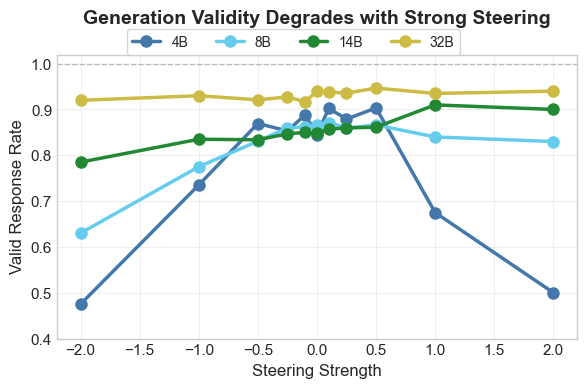


Key observations:
- Average baseline (strength=0) validity: 85.9%
- Average strong positive (strength=2) validity: 76.8%
- Average strong negative (strength=-2) validity: 70.6%


In [10]:
# Line plot: validity rate vs steering strength by model size
fig, ax = plt.subplots(figsize=(6, 4))

# Order model sizes
MODEL_SIZES = ["4B", "8B", "14B", "32B"]

model_colors = {
    "4B": "#4477AA",
    "8B": "#66CCEE", 
    "14B": "#228833",
    "32B": "#CCBB44",
}

for model in MODEL_SIZES:
    data = validity_by_model[validity_by_model["model_size"] == model]
    if len(data) > 0:
        data = data.sort_values("strength")
        ax.plot(data["strength"], data["validity_rate"], 
                marker='o', label=model, 
                color=model_colors[model], linewidth=2.5, markersize=8)

ax.set_xlabel("Steering Strength", fontsize=12)
ax.set_ylabel("Valid Response Rate", fontsize=12)
ax.set_title("Generation Validity Degrades with Strong Steering", 
             fontsize=14, fontweight='bold', y=1.08)
ax.set_ylim(0.4, 1.02)
ax.grid(True, alpha=0.3)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Legend at top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(MODEL_SIZES),
           fontsize=10, frameon=True, bbox_to_anchor=(0.5, 0.93))

plt.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig("../results/generations/validity_rate_by_model_size_and_strength.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nKey observations:")
baseline = validity_by_model[validity_by_model["strength"] == 0.0]["validity_rate"].mean()
strong_pos = validity_by_model[validity_by_model["strength"] == 2.0]["validity_rate"].mean()
strong_neg = validity_by_model[validity_by_model["strength"] == -2.0]["validity_rate"].mean()
print(f"- Average baseline (strength=0) validity: {baseline:.1%}")
print(f"- Average strong positive (strength=2) validity: {strong_pos:.1%}")
print(f"- Average strong negative (strength=-2) validity: {strong_neg:.1%}")